In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
from NEF_WM import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [3]:
def bayes(empirical, stage):
    subdata = empirical.query("stage<=@stage")
    reds = subdata.query("color==1")['color'].size
    p_star = (reds+1)/(stage+2)
    expectation = 2*p_star-1
    return expectation

In [4]:
def run_WM_carrabin(sid, trial, n_neurons):
    empirical = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid & trial==@trial")
    columns = ['type', 'n_neurons', 'sid', 'trial', 'stage', 'delta N', 'delta E']
    dfs = []
    env = Environment(dataset="carrabin", sid=sid, trial=trial)
    seed_net = sid + 1000*trial
    net, sim = simulate_WM(env=env, n_neurons=n_neurons, seed_net=seed_net, z=0, progress_bar=False)
    for stage in env.stages:
        tidx = int((stage*env.T)/env.dt)-2
        number = sim.data[net.probe_number][tidx][0]
        expectation_NEF = sim.data[net.probe_memory][tidx][0]
        expectation_bayes = bayes(empirical, stage)
        delta_N = np.abs(number - stage) / stage
        delta_E = np.abs(expectation_NEF - expectation_bayes)
        df = pd.DataFrame([['NEF_WM', n_neurons, sid, trial, stage, delta_N, delta_E]], columns=columns)
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    # data.to_pickle(f"data/NEF_WM_carrabin_{sid}_{trial}_{n_neurons}.pkl")
    return data

In [22]:
run_WM_carrabin(1, 1, 1000)

,type,n_neurons,sid,trial,stage,delta N,delta E
0,NEF_WM,1000,1,1,1,0.026864,0.027625
1,NEF_WM,1000,1,1,2,0.021896,0.012518
2,NEF_WM,1000,1,1,3,0.026182,0.005162
3,NEF_WM,1000,1,1,4,0.028327,0.022722
4,NEF_WM,1000,1,1,5,0.028380,0.008886


In [39]:
empirical = pd.read_pickle(f"data/carrabin.pkl")
sids = empirical['sid'].unique()[:1]
trials = empirical['trial'].unique()
n_neurons = [200, 400, 600, 800, 1000]

start = time.time()
dfs = []
for sid in sids:
    for trial in trials:
        for n in n_neurons:
            print(f"sid {sid}, trial {trial}, neurons {n}")
            dfs.append(run_WM_carrabin(sid, trial, n))
noise_data = pd.concat(dfs, ignore_index=True)
end = time.time()
print(f"runtime {(end-start)/60:.4} min")

sid 1, trial 1, neurons 200
sid 1, trial 1, neurons 400
sid 1, trial 1, neurons 600
sid 1, trial 1, neurons 800
sid 1, trial 1, neurons 1000
sid 1, trial 2, neurons 200
sid 1, trial 2, neurons 400
sid 1, trial 2, neurons 600
sid 1, trial 2, neurons 800
sid 1, trial 2, neurons 1000
sid 1, trial 3, neurons 200
sid 1, trial 3, neurons 400
sid 1, trial 3, neurons 600
sid 1, trial 3, neurons 800
sid 1, trial 3, neurons 1000
sid 1, trial 4, neurons 200
sid 1, trial 4, neurons 400
sid 1, trial 4, neurons 600
sid 1, trial 4, neurons 800
sid 1, trial 4, neurons 1000
sid 1, trial 5, neurons 200
sid 1, trial 5, neurons 400
sid 1, trial 5, neurons 600
sid 1, trial 5, neurons 800
sid 1, trial 5, neurons 1000
sid 1, trial 6, neurons 200
sid 1, trial 6, neurons 400
sid 1, trial 6, neurons 600
sid 1, trial 6, neurons 800
sid 1, trial 6, neurons 1000
sid 1, trial 7, neurons 200
sid 1, trial 7, neurons 400
sid 1, trial 7, neurons 600
sid 1, trial 7, neurons 800
sid 1, trial 7, neurons 1000
sid 1, trial 

In [40]:
noise_data.to_pickle("data/noise_carrabin.pkl")

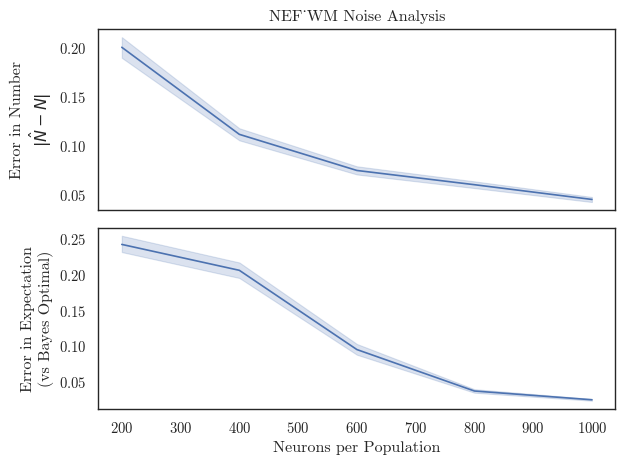

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.lineplot(noise_data, x='n_neurons', y='delta N', ax=axes[0])
sns.lineplot(noise_data, x='n_neurons', y='delta E', ax=axes[1])
axes[0].set(ylabel='Error in Number\n'+r"$|\hat{N} - N|$", title='NEF_WM Noise Analysis')
axes[1].set(ylabel='Error in Expectation\n(vs Bayes Optimal)', xlabel='Neurons per Population')
plt.tight_layout()
plt.show()
fig.savefig("plots/NEF_WM_noise_analysis.jpg", dpi=600)

# Load and Plot

In [6]:
# noise_data1 = pd.read_pickle("data/NEF_WM_noise_WM_carrabin_jan31.pkl")
# noise_data2 = pd.read_pickle("data/NEF_WM_noise_WM_carrabin_feb3.pkl")
noise_data = pd.read_pickle("data/NEF_WM_noise_WM_carrabin_feb4.pkl")
# noise_data = pd.concat([noise_data1, noise_data2])
# noise_data = noise_data2

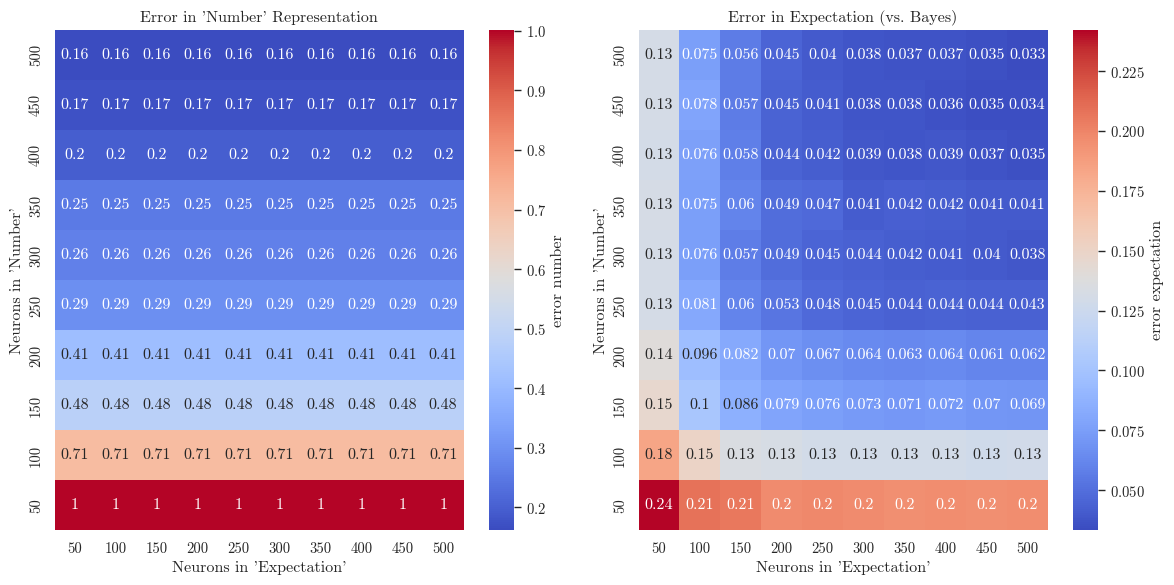

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
error_number = noise_data.pivot_table(index='n_number', columns='n_working', values='error number', aggfunc='mean')
error_expectation = noise_data.pivot_table(index='n_number', columns='n_working', values='error expectation', aggfunc='mean')
sns.heatmap(data=error_number, annot=True, cmap="coolwarm", cbar_kws={'label': 'error number'}, ax=axes[0])
sns.heatmap(data=error_expectation, annot=True, cmap="coolwarm", cbar_kws={'label': 'error expectation'}, ax=axes[1])
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set(xlabel="Neurons in 'Expectation'", ylabel="Neurons in 'Number'", title="Error in 'Number' Representation")
axes[1].set(xlabel="Neurons in 'Expectation'", ylabel="Neurons in 'Number'", title="Error in Expectation (vs. Bayes)")
plt.tight_layout()
fig.savefig("plots/noise_WM_vs_neurons.jpg", dpi=600)

In [70]:
noise_data

,type,n_number,n_working,sid,trial,stage,error number,error expectation
0,NEF_WM,200,200,1,1,1,0.558746,0.016284
1,NEF_WM,200,200,1,1,2,0.602081,0.090963
2,NEF_WM,200,200,1,1,3,0.653072,0.084821
3,NEF_WM,200,200,1,1,4,0.676895,0.152489
4,NEF_WM,200,200,1,1,5,0.699672,0.148075
...,...,...,...,...,...,...,...,...
24995,NEF_WM,1000,1000,1,200,1,0.032007,0.005155
24996,NEF_WM,1000,1000,1,200,2,0.053405,0.001611
24997,NEF_WM,1000,1000,1,200,3,0.060776,0.011790
24998,NEF_WM,1000,1000,1,200,4,0.071280,0.007228


## Mathematical model, add gaussian noise and test performance

In [8]:
def bayes_ideal(obs):
    stage = len(obs)
    reds = len(np.where(obs==1)[0])
    p_star = (reds+1)/(stage+2)
    expectation = 2*p_star-1
    return expectation

In [9]:
def bayes_noise(obs, noise_n=0, noise_e=0, seed=0):
    rng = np.random.RandomState(seed=seed)
    expectation = 0
    for o in range(len(obs)):
        weight = 1/(o+3)
        dW = rng.uniform((1-noise_n)*weight, (1+noise_n)*weight)
        weight = dW
        weight = np.clip(weight, 0, 1)
        error = obs[o] - expectation
        expectation += weight * error
        dE = rng.uniform((1-noise_e)*expectation, (1+noise_e)*expectation)
        expectation = dE
        expectation = np.clip(expectation, -1, 1)
    weight_ideal = 1/(o+3)
    expectation_ideal = bayes_ideal(obs)
    return weight_ideal, weight, expectation_ideal, expectation

In [10]:
sid = 1
noises_n = np.linspace(1, 0, 10)
noises_e = np.linspace(1, 0, 10)
dfs = []
columns = ['type', 'sid', 'trial', 'stage', 'noise n', 'noise e', 'error number', 'error expectation']
sids = pd.read_pickle("data/carrabin.pkl")['sid'].unique()
for sid in sids[:3]:
    trials = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")['trial'].unique()
    stages = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")['stage'].unique()
    for n1 in noises_n:
        for n2 in noises_e:
            for trial in trials:
                for stage in stages:
                    obs = pd.read_pickle("data/carrabin.pkl").query("sid==@sid & trial==@trial & stage<=@stage")['color'].to_numpy()
                    seed = int(10*n1 + 100*n2 + 1000*trial + 10000*stage)
                    weight_ideal, weight, expectation_ideal, expectation = bayes_noise(obs, noise_n=n1, noise_e=n2, seed=seed)
                    delta_n = np.around(np.abs(weight_ideal - weight)/stage, 4)
                    delta_e = np.around(np.abs(expectation_ideal - expectation), 4)
                    dfs.append(pd.DataFrame([['noisy bayes', sid, trial, stage, np.around(n1, 2), np.around(n2, 2), delta_n, delta_e]], columns=columns))
bayes_noise_data = pd.concat(dfs, ignore_index=True)
bayes_noise_data.to_pickle("data/bayes_noise.pkl")

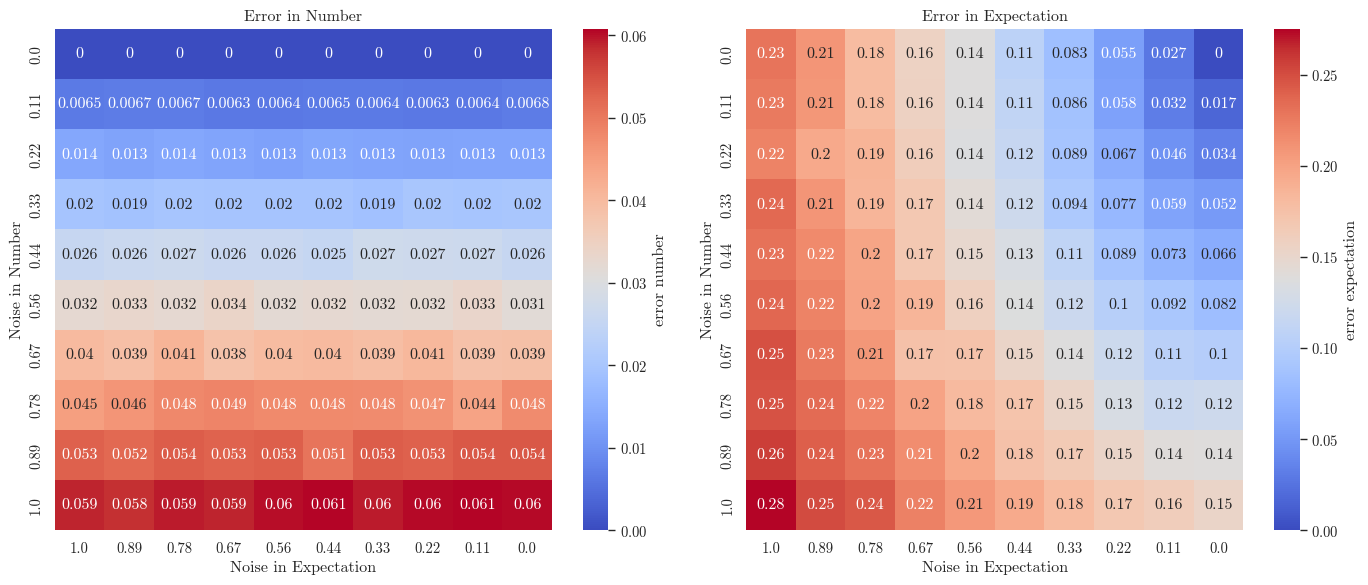

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=False)
error_number = bayes_noise_data.pivot_table(index='noise n', columns='noise e', values='error number', aggfunc='mean')
error_expectation = bayes_noise_data.pivot_table(index='noise n', columns='noise e', values='error expectation', aggfunc='mean')

sns.heatmap(data=error_number, annot=True, cmap="coolwarm", cbar_kws={'label': 'error number'}, ax=axes[0])
sns.heatmap(data=error_expectation, annot=True, cmap="coolwarm", cbar_kws={'label': 'error expectation'}, ax=axes[1])
# axes[0].invert_yaxis()
# axes[1].invert_yaxis()
axes[0].invert_xaxis()
axes[1].invert_xaxis()
axes[0].set(xlabel="Noise in Expectation", ylabel="Noise in Number", title="Error in Number")
axes[1].set(xlabel="Noise in Expectation", ylabel="Noise in Number", title="Error in Expectation")
plt.tight_layout()
fig.savefig("plots/noise_bayes.jpg", dpi=600)

In [173]:
error_number

noise e,0.00,0.11,0.22,0.33,0.44,0.56,0.67,0.78,0.89,1.00
noise n,,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.11,0.006805,0.006405,0.006274,0.006426,0.006545,0.006361,0.006256,0.006713,0.006742,0.006520
0.22,0.013143,0.013215,0.012928,0.013206,0.013365,0.012587,0.013152,0.013692,0.013037,0.013743
0.33,0.020033,0.019841,0.019996,0.018862,0.019685,0.019510,0.019516,0.019883,0.019019,0.019691
0.44,0.025541,0.026759,0.027068,0.027293,0.025282,0.026000,0.026061,0.026801,0.026219,0.025639
0.56,0.031425,0.033426,0.032274,0.032015,0.032487,0.032041,0.033743,0.032398,0.033101,0.032490
0.67,0.038858,0.038612,0.040539,0.039311,0.040081,0.039883,0.038430,0.041310,0.039114,0.040049
0.78,0.047554,0.044115,0.046590,0.047569,0.047898,0.047956,0.048514,0.048039,0.046192,0.044717
0.89,0.053933,0.054046,0.052959,0.053476,0.050734,0.053406,0.052823,0.053513,0.052088,0.052997
